pip install -e /engelhardt/home/pshrestha/nsf-paper

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.gp import SVGP, VNNGP
from gpzoo.kernels import NSF_RBF, RBF
from gpzoo.likelihoods import GaussianLikelihood, NSF2
import squidpy as sq
import numpy as np
from gpzoo.utilities import train, deviancePoisson, rescale_spatial_coords, anndata_to_train_val, regularized_nmf
import gpzoo.pri_experiment_utilities as putil
import time
import scanpy as sc
import random
from os import path
from math import ceil
from copy import deepcopy
from scipy import sparse
from contextlib import suppress
from scanpy import read_h5ad
from tensorflow import constant
from tensorflow.data import Dataset
from sklearn.cluster import KMeans

/engelhardt/home/pshrestha/vnngp/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-06-29 16:50:44.321460: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-29 16:50:44.366604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-29 16:50:44.873024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
random.seed(256)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
root_path = '/engelhardt/home/pshrestha/vnngp'

In [5]:
def center_data(Dtr_n,Dval_n=None):
  Dtr_c = deepcopy(Dtr_n)
  feature_means=Dtr_c["Y"].mean(axis=0)
  Dtr_c["Y"] -= feature_means
  if Dval_n:
    Dval_c = deepcopy(Dval_n)
    Dval_c["Y"] -= feature_means
  else:
    Dval_c = None
  return feature_means,Dtr_c,Dval_c

def prepare_datasets_tf(Dtrain,Dval=None,shuffle=False,batch_size=None):
  """
  Dtrain and Dval are dicts containing numpy np.arrays of data.
  Dtrain must contain the key "Y"
  Returns a from_tensor_slices conversion of Dtrain and a dict of tensors for Dval
  """
  Ntr = Dtrain["Y"].shape[0]
  if batch_size is None:
    #ie one batch containing all observations by default
    batch_size = Ntr
  else:
    batch_size = minibatch_size_adjust(Ntr,batch_size)
  Dtrain = Dataset.from_tensor_slices(Dtrain)
  if shuffle:
    Dtrain = Dtrain.shuffle(Ntr)
  Dtrain = Dtrain.batch(batch_size)
  if Dval is not None:
    Dval = {i:constant(Dval[i]) for i in Dval}
  return Dtrain, Ntr, Dval

In [6]:
def scanpy_sizefactors(Y):
  sz = Y.sum(axis=1,keepdims=True)
  return sz/np.median(sz)

In [7]:
def heatmap(X,y,figsize=(6,4),bgcol="gray",cmap="turbo",**kwargs):
  fig,ax=plt.subplots(figsize=figsize)
  ax.set_facecolor(bgcol)
  ax.scatter(X[:,0],X[:,1],c=y,cmap=cmap,**kwargs)
  # fig.show()

# Visium

In [8]:
dtp = "float32"
root_path = "/engelhardt/home/pshrestha/vnngp/"
dpth = path.join(root_path, "data/")
mpth = path.join(root_path, "models/")
rpth = path.join(root_path, "results/")
visium_pth = path.join(rpth, "paper_visium/")
#nmf_pth = path.join(rpth, "nmf/")
#pnmf_pth = path.join(rpth, "pnmf/")
#nsf_pth = path.join(rpth, "nsf/")
#nnnsf_pth = path.join(rpth, "nnnsf/")

%%sh
mkdir -p /engelhardt/home/pshrestha/vnngp/data/original
pushd /engelhardt/home/pshrestha/vnngp/data/original
wget https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Mouse_Brain_Sagittal_Anterior/V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5
wget https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Mouse_Brain_Sagittal_Anterior/V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz
tar -xzf V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz
rm V1_Mouse_Brain_Sagittal_Anterior_spatial.tar.gz

In [9]:
# following NSF preprocessing
ad = sc.read_visium(path.join(root_path,"data/original"),
                    count_file="V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5")
ad.var_names_make_unique()
ad.var["mt"] = ad.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)
ad = ad[ad.obs.pct_counts_mt < 20]
sc.pp.filter_genes(ad, min_cells=1)
sc.pp.filter_cells(ad, min_counts=100)
ad.layers = {"counts":ad.X.copy()} #store raw counts before normalization changes ad.X


sc.pp.normalize_total(ad, inplace=True, layers=None, key_added="sizefactor") #normalized total counts per cell to a common value
sc.pp.log1p(ad) # performs a log transformation to the data

/engelhardt/home/pshrestha/anaconda3/envs/vnngp/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/engelhardt/home/pshrestha/anaconda3/envs/vnngp/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/engelhardt/home/pshrestha/anaconda3/envs/vnngp/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [10]:
ad.var['deviance_poisson'] = deviancePoisson(ad.layers["counts"])
o = np.argsort(-ad.var['deviance_poisson'])
idx = list(range(ad.shape[0]))
random.shuffle(idx)
ad = ad[idx,o]
ad.write_h5ad(path.join(root_path,"data/visium_brain_sagittal.h5ad"),compression="gzip")
ad2 = ad[:,:2000]
ad2.write_h5ad(path.join(root_path,"data/visium_brain_sagittal_J2000.h5ad"),compression="gzip")

/engelhardt/home/pshrestha/anaconda3/envs/vnngp/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c
/engelhardt/home/pshrestha/anaconda3/envs/vnngp/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [11]:
ad

AnnData object with n_obs × n_vars = 2487 × 21268
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sizefactor'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'deviance_poisson'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

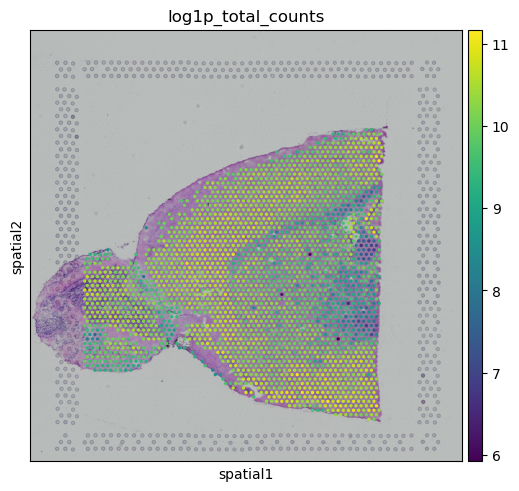

In [12]:
sq.pl.spatial_scatter(ad, color="log1p_total_counts")

Dtr_n['X'] shape: (2363, 2)
Dtr_n['Y'] shape: (2363, 21268)
Dtr['X'] shape: (2363, 2)
Dtr['Y'] shape: (2363, 21268)


2024-06-29 16:50:58.116857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18921 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:65:00.0, compute capability: 8.0
2024-06-29 16:50:58.119445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 4894 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:ca:00.0, compute capability: 8.0


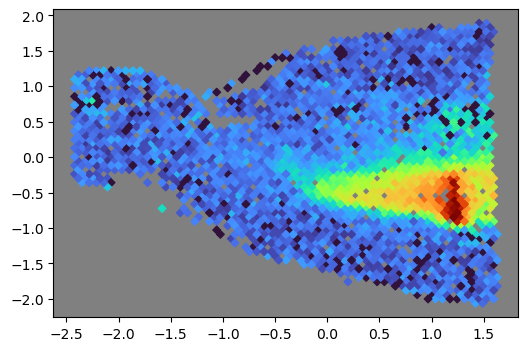

In [13]:
J = 2000
#ad = read_h5ad(path.join(dpth,f"visium_brain_sagittal_J{J}.h5ad"))#[:,:J]
ad = read_h5ad(path.join(dpth,f"visium_brain_sagittal.h5ad"))#[:,:J]
Dtr,Dval = anndata_to_train_val(ad,layer="counts",sz="scanpy")
Dtr_n,Dval_n = anndata_to_train_val(ad) #normalized data

fmeans, Dtr_c, Dval_c = center_data(Dtr_n,Dval_n) #centered features
Xtr = Dtr["X"] #note this should be identical to Dtr_n["X"]
Ntr = Xtr.shape[0]

print(f"Dtr_n['X'] shape: {Dtr_n['X'].shape}")
print(f"Dtr_n['Y'] shape: {Dtr_n['Y'].shape}")

print(f"Dtr['X'] shape: {Dtr['X'].shape}")
print(f"Dtr['Y'] shape: {Dtr['Y'].shape}")

Dtf = prepare_datasets_tf(Dtr,Dval=Dval,shuffle=False)
Dtf_n = prepare_datasets_tf(Dtr_n,Dval=Dval_n,shuffle=False)
Dtf_c = prepare_datasets_tf(Dtr_c,Dval=Dval_c,shuffle=False)

heatmap(Xtr,Dtr_n["Y"][:,0],marker="D",s=15)

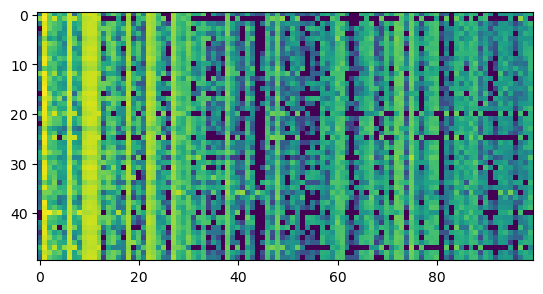

In [14]:
plt.imshow(np.log1p(Dtr_n["Y"])[:50,:100]) # raw data

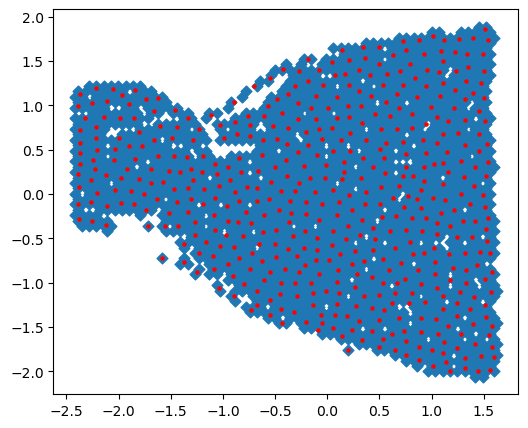

In [15]:
# Visualize Inducing Points
centers = putil.inducing_points_cluster_centers(Xtr, 500)
Z = nn.Parameter(torch.tensor(centers.cluster_centers_).type(torch.float))
Z = Z.detach().numpy()
fig,ax=plt.subplots(figsize=(6,5))
ax.scatter(Xtr[:,0],Xtr[:,1],marker="D",s=30,)
ax.scatter(Z[:,0],Z[:,1],c="red",s=5)

In [16]:
save_path = path.join(visium_pth, "/nsf")

## NMF

L = [5, 8, 10, 12, 15]
max_iter = 1000

for l in L:
    start = time.time()
    factors, loadings = regularized_nmf(Dtr_n['Y'].T, L=l, max_iter = 1000, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=256)
    end = time.time()
    total_time = end - start

    factors = torch.tensor(factors)
    loadings = torch.tensor(loadings)

    nmf_visium_save_pth = path.join(visium_pth, f"nmf/nmf_factors_iter={max_iter}_rs=256_L={l}.pt")
    torch.save({'factors': factors, 'loadings': loadings, 'time': total_time}, nmf_visium_save_pth)
    print('Done')

# NSF

In [17]:
def run_validation_experiment(X, Y, save_path, steps=1000, batched=False, model_type=None, NMF=False, nmf_path=None, **kwargs):
    if torch.cuda.is_available():
        my_device = torch.device('cuda')
    else:
        my_device=torch.device('cpu')
    print(my_device)
        
    kwargs = kwargs['kwargs']
    file_path = model_type
    if model_type == 'VNNGP':
        #K=kwargs['K']
        file_path += f"_K={kwargs['K']}"

        if kwargs['lkzz_build']:
            file_path += f"_lkzz={kwargs['lkzz_build']}"
        
    file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_iter={steps}"
    if batched:
        file_path += f"_bs={kwargs['batch_size']}"
    
    factors = None
    loadings = None

    X = torch.tensor(X, device=my_device)
    Y = torch.tensor(X, device=my_device)
    
    if NMF:
        # with NMF initialization
        file_path += f"_NMFinit"
        factors, loadings = putil.preloaded_nmf_factors(nmf_path)
        X_np = X.clone().to('cpu').numpy()
        moran_idx, moranI = putil.dims_autocorr(factors, X_np)
        factors=factors[:, moran_idx]
        loadings=loadings[:, moran_idx]
        loadings = torch.tensor(loadings, device=my_device)
        factors = torch.tensor(factors, device=my_device)
        model = build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
    else:
        # without NMF initialization
        X = np.array(X)
        model = build_model(X, Y, model_type=model_type, kwargs=kwargs)
        
        

    #model = build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
    model_grads(model)
    model.prior.jitter=kwargs['jtr']
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
    
    model.to(device)
    #X = torch.tensor(X).type(torch.float)
    #Y = torch.tensor(Y).type(torch.float)
    #X_train = X.to(device)
    #Y_train = Y.to(device)
    
    start_time = time.time()
    losses, means, scales, idxs = train_new_KL_batched(model, optimizer, X, Y, device,
                                                steps=steps, E=3, batch_size=kwargs['batch_size'])
    end_time = time.time()
    
    final_time = end_time - start_time
    
    torch.save(model.state_dict(), f'{save_path}/{file_path}_state_dict.pth')
    torch.save({'losses': losses,
                'means': means,
                'scales': scales,
                'time': final_time},
               f'{save_path}/{file_path}_model.pt')
    
    fig, ax = plt.subplots()
    ax.plot(losses)
    fig.suptitle(f"{model_type} Loss")
    fig.savefig(f'{save_path}/{file_path}_loss.png')
    fig.close()
    
    size=2
    fig, axes = plt.subplots(3, 5, figsize=(size*5, size*3), tight_layout=True)
    
    model.cpu()
    qF, _, _ = model.prior(X)
    mean = torch.exp(qF.mean).detach().numpy()
    
    plot_factors(mean, X, moran_idx=moran_idx, size=2, s=1, alpha=0.9, ax=axes)
    fig.suptitle(f'Factors')
    fig.savefig(f'{save_path}/{file_path}_plot.png')
    fig.close()

In [18]:
def build_model(X, Y, loadings=None, factors=None, model_type=None, **kwargs):
    """
    Parameters:
    X:
        - torch.Size([N, D])
    Y:
        - torch.Size([L, N])
    loadings:
        - torch.Size([L, K])
    factors:
        - torch.Size([N, L])
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    Y_np = Y.clone().to('cpu').numpy()
    V = scanpy_sizefactors(Y_np)
    V = torch.tensor(V).to(device)
    #X = torch.tensor(X).type(torch.float).to(device)
    #Y = torch.tensor(Y).type(torch.float).to(device)
    kwargs = kwargs['kwargs']
    X_np = X.clone()
    Xnp = X_np.to('cpu').numpy()
    kmeans = putil.inducing_points_cluster_centers(X_np, kwargs['M'], random_state=kwargs['rs'])
    Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float).to(device))
    kernel = NSF_RBF(L=kwargs['L'], sigma=kwargs['sigma'], lengthscale=kwargs['lengthscale'])
    
    gp = None
    if model_type == 'VNNGP':
        gp = VNNGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'], K=kwargs['K'])
    elif model_type == 'SVGP':
        gp = SVGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'])

    #X = torch.tensor(X).type(torch.float)
    #Y = torch.tensor(Y).type(torch.float)
    Kzx = kernel.forward(Z, X)
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)

    all_factors = torch.tensor(factors.T)[:, :, None].type(torch.float).to(device)
    L1 = torch.linalg.cholesky(add_jitter(Kzx @ Kxz, 1e-4)).to(device)
    
    solved1 = torch.cholesky_solve(Kzx @ all_factors, L1).to(device)
    mu = (Kzz @ solved1).to(device)
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float).to(device)
    
    Lu = 1e-2 * torch.eye(kwargs['M']).expand(kwargs['L'], kwargs['M'], kwargs['M']).to(device)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    model = NSF2(gp, Y, L=kwargs['L']).to(device)

    if loadings is not None:
        model.W = nn.Parameter(torch.tensor(init_softplus(loadings)[:, :kwargs['L']]).type(torch.float).to(device))
    model.V = nn.Parameter(torch.squeeze(torch.tensor(init_softplus(V)).type(torch.float)).to(device))
    
    model.to(device)
    return model

In [19]:
import torch
import numpy as np
from torch import nn, optim
from sklearn.cluster import KMeans

# Ensure the device is set globally
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def build_model(X, Y, loadings=None, factors=None, model_type=None, **kwargs):
    """
    Parameters:
    X:
        - torch.Size([N, D])
    Y:
        - torch.Size([L, N])
    loadings:
        - torch.Size([L, K])
    factors:
        - torch.Size([N, L])
    """
    # Move input data to the device
    X = torch.tensor(X).type(torch.float).to(device)
    Y = torch.tensor(Y).type(torch.float).to(device)
    if loadings is not None:
        loadings = torch.tensor(loadings).type(torch.float).to(device)
    if factors is not None:
        factors = torch.tensor(factors).type(torch.float).to(device)

    V = torch.tensor(scanpy_sizefactors(Y.cpu().numpy().T)).type(torch.float).to(device)
    kwargs = kwargs['kwargs']

    kmeans = putil.inducing_points_cluster_centers(X.cpu().numpy(), kwargs['M'], random_state=kwargs['rs'])
    Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float).to(device))
    kernel = NSF_RBF(L=kwargs['L'], sigma=kwargs['sigma'], lengthscale=kwargs['lengthscale'])
    
    gp = None
    if model_type == 'VNNGP':
        gp = VNNGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'], K=kwargs['K'])
    elif model_type == 'SVGP':
        gp = SVGP(kernel, M=kwargs['M'], jitter=kwargs['jtr'])
        
    Kzx = kernel.forward(Z, X)
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)

    if factors is not None:
        all_factors = factors.T[:, :, None].type(torch.float).to(device)
        L1 = torch.linalg.cholesky(add_jitter(Kzx @ Kxz, 1e-4)).to(device)
        solved1 = torch.cholesky_solve(Kzx @ all_factors, L1).to(device)
        mu = (Kzz @ solved1).to(device)
        gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float).to(device)
    else:
        gp.mu = nn.Parameter(torch.zeros(Kzz.shape[0]).to(device))

    Lu = 1e-2 * torch.eye(kwargs['M']).expand(kwargs['L'], kwargs['M'], kwargs['M']).to(device)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    model = NSF2(gp, Y, L=kwargs['L']).to(device)

    if loadings is not None:
        model.W = nn.Parameter(torch.tensor(init_softplus(loadings)[:, :kwargs['L']]).type(torch.float).to(device))
    model.V = nn.Parameter(torch.squeeze(torch.tensor(init_softplus(V)).type(torch.float)).to(device))
    
    return model

def run_validation_experiment(X, Y, save_path, steps=1000, batched=False, model_type=None, NMF=False, nmf_path=None, **kwargs):
    kwargs = kwargs['kwargs']
    file_path = model_type
    if model_type == 'VNNGP':
        file_path += f"_K={kwargs['K']}"

        if kwargs['lkzz_build']:
            file_path += f"_lkzz={kwargs['lkzz_build']}"
        
    file_path += f"_M={kwargs['M']}_L={kwargs['L']}_lr={kwargs['lr']}_jtr={kwargs['jtr']}_iter={steps}"
    if batched:
        file_path += f"_bs={kwargs['batch_size']}"
    
    factors = None
    loadings = None
    
    if NMF:
        file_path += f"_NMFinit"
        factors, loadings = putil.preloaded_nmf_factors(nmf_path)
        moran_idx, moranI = putil.dims_autocorr(factors, X)
        factors = factors[:, moran_idx]
        loadings = loadings[:, moran_idx]
        model = build_model(X, Y, loadings=loadings, factors=factors, model_type=model_type, kwargs=kwargs)
    else:
        model = build_model(X, Y, model_type=model_type, kwargs=kwargs)

    model_grads(model)
    model.prior.jitter = kwargs['jtr']
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=kwargs['lr'])
    
    model.to(device)
    X = torch.tensor(X).type(torch.float).to(device)
    Y = torch.tensor(Y).type(torch.float).to(device)

    start_time = time.time()
    losses, means, scales, idxs = train_new_KL_batched(model, optimizer, X, Y, device, steps=steps, E=3, batch_size=kwargs['batch_size'])
    end_time = time.time()
    
    final_time = end_time - start_time
    
    torch.save(model.state_dict(), f'{save_path}/{file_path}_state_dict.pth')
    torch.save({'losses': losses, 'means': means, 'scales': scales, 'time': final_time}, f'{save_path}/{file_path}_model.pt')
    
    fig, ax = plt.subplots()
    ax.plot(losses)
    fig.suptitle(f"{model_type} Loss")
    fig.savefig(f'{save_path}/{file_path}_loss.png')
    plt.close(fig)
    
    size = 2
    fig, axes = plt.subplots(3, 5, figsize=(size*5, size*3), tight_layout=True)
    
    model.cpu()
    qF, _, _ = model.prior(X.cpu())
    mean = torch.exp(qF.mean).detach().numpy()
    
    plot_factors(mean, X.cpu().numpy(), moran_idx=moran_idx, size=2, s=1, alpha=0.9, ax=axes)
    fig.suptitle(f'Factors')
    fig.savefig(f'{save_path}/{file_path}_plot.png')
    plt.close(fig)


In [20]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [21]:
L = [5, 8, 10, 12, 15]
L= [15]
M = [500, 1000, 2000, 3000, 5000]
K = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
lkzz_builds = [1]

In [22]:
save_path = path.join(visium_pth, "/nsf")

#outputs_dict = defaultdict(list)
for m in M:
    for l in L:
        file_path = path.join(save_path, f"SVGP_M={m}_L={l}_lr=0.001_jtr=0.01_iter=100_bs=128_NMFinit_model.pt")
        if not path.isfile(file_path):
            print(f"{file_path} does not exist. Running the code...")
            dicts = {
                    'L': l, 
                    'M': m, 
                    #'K': k,
                    'sigma': 0.1, 
                    'lengthscale': 0.07, 
                    'jtr': 1e-2,
                    'batch_size': 128,
                    'lr': 1e-3,
                    'rs': 256}
                    #'lkzz_build': l}
            nmf_path = path.join(root_path, f"results/paper_visium/nmf/nmf_factors_iter=1000_rs=256_L={dicts['L']}.pt")
            putil.run_validation_experiment(Dtr['Y'].T, Dtr['X'], save_path, steps=100, batched=True,
                             model_type='SVGP', NMF=True, nmf_path=nmf_path, kwargs=dicts)
            plt.close('all')
        else:
            print(f"{file_path} exists. Skipping the code.")

/nsf/SVGP_M=500_L=15_lr=0.001_jtr=0.01_iter=100_bs=128_NMFinit_model.pt does not exist. Running the code...


  0%|                                                                                                   | 0/100 [00:00<?, ?it/s]/opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [64,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [65,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [66,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [67,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of b

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
